In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.patches as mpatches
import sys
sys.path.insert(1, 'code')
from help_funcs import *
import matplotlib
import scipy.io
matplotlib.rcParams.update({'font.size': 18})

REVISION_DATA_DIR ='compiled_data'

## Response Fig 3A (numbering from modeling draft)

In [ ]:
## Compile firing rates from sim data and save mat file

simname = 'dl'
seed = 2
seedlist = [i for i in range(2,22)]
binlen = 200
nsecs = 5
delay = 200
stimargs = {'binlen': binlen, 'delay': delay, 'nrepeats' : 6}

all_spont_E, all_spont_P, all_spont_S = [], [], []

for del_range in [0.0, 0.3, 1.0]:
    
    spont_E, spont_P, spont_S = [], [], []

    for seed in seedlist:

        folder = 'work_dir/%s_%s/results_%s/'%(simname, del_range, seed)


        try:
            with open(folder + 'Spont_spikes.pickle', 'rb') as f:
                all_spikes = pickle.load(f)
            with open(folder + 'Spont_positions.pickle', 'rb') as f:
                all_positions = pickle.load(f)
        except FileNotFoundError:
            not_all_found = True
            print(folder, 'not found')
            continue

        spont_E_mean, spont2_E_mean, spont_E_err, spont2_E_err = getStimRateMeans_v2(all_spikes[:8000], all_positions[:8000],**stimargs)
        spont_P_mean, spont2_P_mean, spont_P_err, spont2_P_err = getStimRateMeans_v2(all_spikes[8000:9000], all_positions[8000:9000], **stimargs)
        spont_S_mean, spont2_S_mean, spont_S_err, spont2_S_err = getStimRateMeans_v2(all_spikes[9000:10000], all_positions[9000:10000], **stimargs)

#         print(spont_E_mean)
        spont_E.append(spont_E_mean)
        spont_P .append(spont_P_mean)
        spont_S .append( spont_S_mean)
        
        if len(spont_E)>=20:
            break

    print(del_range)
    
    all_spont_E.append(spont_E)
    all_spont_P.append(spont_P)
    all_spont_S.append(spont_S)
    
data = {'E_rates_control': np.array(all_spont_E[0][:20]), 'E_rates_inh_removed_locally': np.array(all_spont_E[1][:20]), 
        'E_rates_inh_removed_globally': np.array(all_spont_E[2][:20]),
        'PV_rates_control': np.array(all_spont_P[0][:20]), 'PV_rates_inh_removed_locally': np.array(all_spont_P[1][:20]), 
        'PV_rates_inh_removed_globally': np.array(all_spont_P[2][:20]),
        'SST_rates_control': np.array(all_spont_S[0][:20]), 'SST_rates_inh_removed_locally': np.array(all_spont_S[1][:20]), 
        'SST_rates_inh_removed_globally': np.array(all_spont_S[2][:20])
       }
scipy.io.savemat(f'{REVISION_DATA_DIR}/FigS10A.mat', data)

In [2]:
# OR, collect firing rates from mat file
data = scipy.io.loadmat(f'{REVISION_DATA_DIR}/FigS10A.mat')
all_spont_E = []
all_spont_E.append(data['E_rates_control'].flatten())
all_spont_E.append(data['E_rates_inh_removed_locally'].flatten())
all_spont_E.append(data['E_rates_inh_removed_globally'].flatten())


<function matplotlib.pyplot.show(close=None, block=None)>

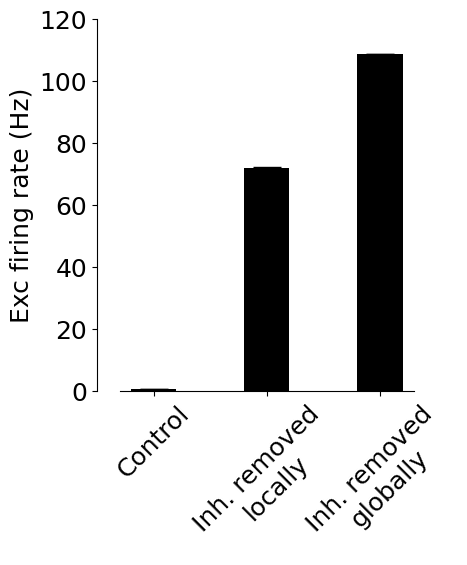

In [3]:
fig, ax = plt.subplots(figsize=(5, 6))
for di in range(3):
    ax.bar(di, np.mean(all_spont_E[di]), facecolor='black', width=0.4)
    ax.errorbar(di, np.mean(all_spont_E[di]), yerr=scipy.stats.sem(all_spont_E[di]), c='black', capsize=10)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Detach left and bottom spines
# ax.spines['left'].set_linestyle('--')
# ax.spines['bottom'].set_linestyle('--')

plt.gca().spines['left'].set_position(('data', -0.5))
plt.gca().spines['bottom'].set_position(('data', -0.05))

plt.subplots_adjust(left=0.25,bottom=0.25)

ax. set_xlim(-.3,2.3)
ax.set_ylim(0,120)

ax.set_ylabel('Exc firing rate (Hz)')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Control', 'Inh. removed\nlocally', 'Inh. removed\nglobally'], rotation=45)

# plt.show()
plt.tight_layout()
plt.show

## Response Fig 3B

In [ ]:
## GLOBAL INHIBITION
simname = 'dl_1.0'
contrasts = np.array([0.02, 0.05, 0.1, 0.18, 0.33])
ignor=0

nsims=0

contrast_responses = []

binlen = 200
delay = 200
stimargs = {'binlen': binlen, 'delay': delay, 'nrepeats': 6}

for seed in range(1,25):

    folder = 'work_dir/%s/results_%s/'%(simname, seed)
    
    print(folder)
    not_all_found=False
    for stim_type in ['PV','SOM']:
        ctrl_curve = []
        for ci, cont in enumerate(contrasts):
            print('contrast', cont)

            try:
                with open(folder + '%s_%s_positions.pickle'%(stim_type,cont), 'rb') as f:
                    all_positions = pickle.load(f)
                with open(folder + '%s_%s_spikes.pickle'%(stim_type,cont), 'rb') as f:
                    all_spikes = pickle.load(f)

            except (EOFError, FileNotFoundError) as te:
                print (te)
                not_all_found = True
                break

            ctrlpv_E_mean, stimpv_E_mean, ctrlpv_E_err, stimpv_E_err = getStimRateMeans_v2(all_spikes[:8000], all_positions[:8000], **stimargs)

            ctrl_curve.append(ctrlpv_E_mean)
        
        if len(ctrl_curve)!= len(contrasts):
            continue

        contrast_responses.append(ctrl_curve)
        nsims += 1
        if nsims >=20: ## Collect up to 20 sims
            break
    if nsims >=20: ## Collect up to 20 sims
        break

global_responses = np.array(contrast_responses)

## LOCAL INHIBITION
simname = 'dl_0.3'
contrasts = np.array([0.02, 0.05, 0.1, 0.18, 0.33])
ignor=0
binlen = 100

nsims=0

contrast_responses = []
binlen = 200
delay = 200
stimargs = {'binlen': binlen, 'delay': delay, 'n_repeats': 6}

for seed in range(1,25):
    
    folder = 'work_dir/%s/results_%s/'%(simname, seed)
    
    print(folder)
    not_all_found=False
    for stim_type in ['PV','SOM']:
        ctrl_curve = []
        for ci, cont in enumerate(contrasts):
            print('contrast', cont)

            try:
                with open(folder + '%s_%s_positions.pickle'%(stim_type,cont), 'rb') as f:
                    all_positions = pickle.load(f)
                with open(folder + '%s_%s_spikes.pickle'%(stim_type,cont), 'rb') as f:
                    all_spikes = pickle.load(f)

            except (EOFError, FileNotFoundError) as te:
                print (te)
                not_all_found = True
                break

            ctrlpv_E_mean, stimpv_E_mean, ctrlpv_E_err, stimpv_E_err = getStimRateMeans_v2(all_spikes[:8000], all_positions[:8000], **stimargs)

            ctrl_curve.append(ctrlpv_E_mean)
        
        if len(ctrl_curve)!= len(contrasts):
            continue

        contrast_responses.append(ctrl_curve)
        nsims += 1
        if nsims >=20: ## Collect up to 20 sims
            break
    if nsims >=20: ## Collect up to 20 sims
        break
        
local_responses = np.array(contrast_responses)


In [ ]:
local_average = np.mean(local_responses, axis=0)
global_average = np.mean(global_responses, axis=0)

params, cov = fit_naka_rushton(contrasts, local_average)
local_m, local_C, local_n, local_k = params

params, cov = fit_naka_rushton(contrasts, global_average)
global_m, global_C, global_n, global_k = params

data = {'inh_removed_locally': local_responses, 'inh_removed_globally': global_responses,
       'inh_removed_locally_average': local_average, 'inh_removed_globally_average': global_average,
       'inh_removed_locally_b': local_m, 'inh_removed_locally_Rm': local_C,
        'inh_removed_locally_n': local_n, 'inh_removed_locally_x50': local_k,
        'inh_removed_globally_b': global_m, 'inh_removed_globally_Rm': global_C,
        'inh_removed_globally_n': global_n, 'inh_removed_globally_x50': global_k
       }

scipy.io.savemat(f'{REVISION_DATA_DIR}/FigS10B.mat', data)

In Code parameter names are : 
$$m + C\frac{(x^n)}{(x^n + k^n)}$$

In Paper parameter names are : 
$$b + Rm\frac{(x^n)}{(x^n + x_{50}^n)}$$

In [4]:
# Use precompiled data
data = scipy.io.loadmat(f'{REVISION_DATA_DIR}/FigS10B.mat')
local_m = float(data['inh_removed_locally_b'])
local_C = float(data['inh_removed_locally_Rm'])
local_n = float(data['inh_removed_locally_n'])
local_k = float(data['inh_removed_locally_x50'])
local_average = (data['inh_removed_locally_average'])
local_responses = data['inh_removed_locally']

global_m = float(data['inh_removed_globally_b'])
global_C = float(data['inh_removed_globally_Rm'])
global_n = float(data['inh_removed_globally_n'])
global_k = float(data['inh_removed_globally_x50'])
global_average = data['inh_removed_globally_average']
global_responses = data['inh_removed_globally']

contrasts = np.array([0.02, 0.05, 0.1, 0.18, 0.33])

/scratch/1705688/ipykernel_1524803/3005256902.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  local_m = float(data['inh_removed_locally_b'])
/scratch/1705688/ipykernel_1524803/3005256902.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  local_C = float(data['inh_removed_locally_Rm'])
/scratch/1705688/ipykernel_1524803/3005256902.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  local_n = float(data['inh_removed_locally_n'])
/scratch/1705688/ipykernel_152480

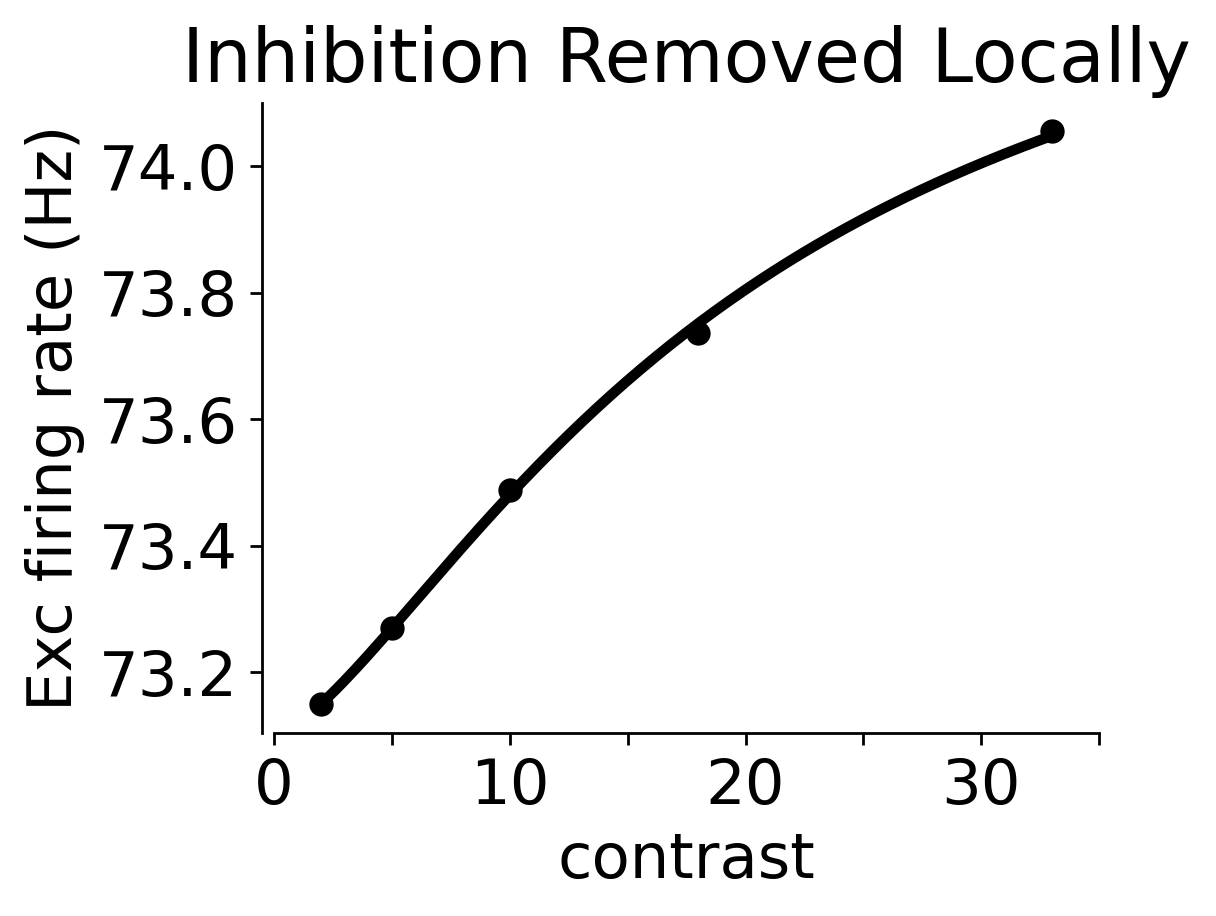

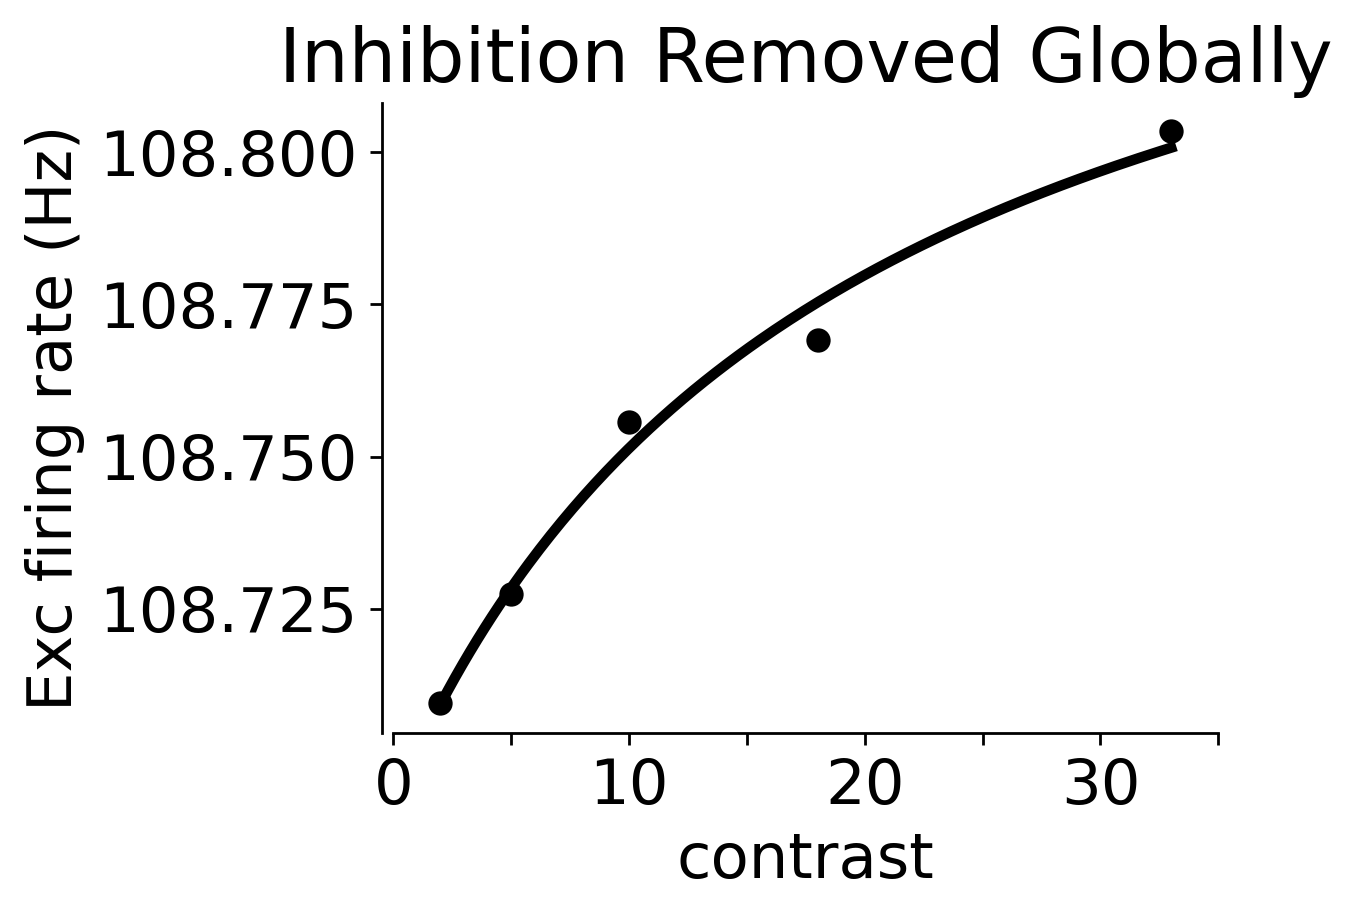

In [6]:

import matplotlib.ticker as mticker
cvals = np.linspace(0.02,0.33,200)
local_yvals = naka_rushton(cvals, local_m, local_C, local_n, local_k)

fig, ax = plt.subplots(figsize=(6, 4), dpi=250)
ax.scatter(contrasts*100, local_average, c='black')
ax.plot(cvals*100, local_yvals, c='black', lw=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().spines['left'].set_position(('data', -0.5))
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.8)
ax.set_xlabel('contrast')

ax.set_ylabel('Exc firing rate (Hz)')
ax.set_xticks([0,5,10,15,20,25,30,35])
ax.set_xticklabels([0,'',10,'',20,'',30,''])
plt.title('Inhibition Removed Locally')
plt.show()

cvals = np.linspace(0.02,0.33,200)
global_yvals = naka_rushton(cvals, global_m, global_C, global_n, global_k)

fig, ax = plt.subplots(figsize=(6, 4), dpi=250)
ax.scatter(contrasts*100, global_average, c='black')
ax.plot(cvals*100, global_yvals, c='black', lw=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().spines['left'].set_position(('data', -0.5))

plt.subplots_adjust(left=0.25, bottom=0.25, right=0.8)
ax.set_xlabel('contrast')

ax.set_ylabel('Exc firing rate (Hz)')
ax.set_xticks([0,5,10,15,20,25,30,35])
ax.set_xticklabels([0,'',10,'',20,'',30,''])
plt.title('Inhibition Removed Globally')

ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

plt.show()